# Pipeline
## Detección de rostros
1. Reproducir código de Santiago para detectar caras
2. Separar rectangulo de cara identificada

## Identificación de tapabocas
Como se sabe qué imágenes tienen tapabocas y cuales no, se puede etiquetar cada imagen con 1 si es con tapabocas y 0 de lo contrario. Por lo tanto los siguientes pasos son:

3. Obtener descriptores para cada imagen y construir dataframe con etiquetas
4. Probar algoritmos

## Opción 3. Use un proyecto anterior de la asignatura de aprendizaje de máquina (con Alex)

Algunos de ustedes, me han comentado acerca de dos proyectos de la asignatura de machine learning.  Uno es la detección de cuando una persona tiene tapabocas y cuando no. El otro es la detección y localización de los ojos en una imagen. Puede escoger cualquiera de estos dos proyectos, pero la idea aquí no es partir directamente de la imagen sino utilizar técnicas de procesamiento de imágenes y visión por computador (no deep learning) en combinación con métodos de machine learning (no necesariamente redes neuronales).  Tendrá que involucrar:

- Técnicas de preprocesado y postprocesado (si segmenta)
- Técnicas de segmentación y/o detección
- Es **obligatorio** extraer descriptores, ya sean locales o de toda la imagen (cuidado con la invarianza).
- Usar un pipeline de machine learning, involucrando diversas etapas y modelos (random forest, LDA, regresión logística, NN, etc) y escoger el mejor modelo. No olvide, evaluar sus resultados en un training y test sets.

Puede serle muy útil emplear un algoritmo de detección de rostros como "Viola-Jones". En un taller de MACC lo expliqué de forma muy sencilla ([en este video](https://youtu.be/0haEygYdHrw?list=PL0vATkTNKgo9NIY8oCL-pAfggflwHHA2O&t=1334)). [Este notebook](https://github.com/santialferez/tallerCV/blob/master/TallerCV.ipynb) (hacía el final) tiene un ejemplo sencillo con una foto mía de hace tiempo.

Para el problema de clasificación de tapabocas puede serle útil [este dataset](https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip) (no use imágenes aumentadas).


In [60]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import os
from copy import deepcopy
from skimage import io
from skimage.transform import resize

from scipy.stats import skew, kurtosis, entropy

# 1. Creación de función para detectar rectangulo de cara

Probaremos la función creada para dos imagenes: con y sin tapabocas

In [58]:
# FUNCIONES AUXILIARES
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def get_face(im, shape=[250,250]):
    """
    Detecta las caras en una imagen con algoritmo Viola-Jones
    
    
    args:
        im: imagen original en RGB
        shape: tamaño del rectangulo donde se detecta la cara
        
    returns:
        seccion de la cara detectada en escala de grises
    """
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    #marked = deepcopy(im)
    roi_color = np.zeros(shape)
    roi_gray = np.zeros(shape)
    for (x,y,w,h) in faces:
        # Seleccion en escala de grises de la cara
        roi_gray = resize(gray[y:y+h, x:x+w],shape)
        # Seleccion a color de la cara
        #roi_color = resize(im[y:y+h, x:x+w],shape)
    return  roi_gray

def get_statistic_features(imgs):
    """
    Calcula métricas estadisticas para un conjunto de imagenes
    
    args:
        imgs: arreglo con las imagenes en escala de grises
        
    returns:
        dataframe con las metricas estadísticas
    """
    #media,desviación estándar, skewness, curtósis, máximo, mínimo, contraste, uniformidad, entropía (ver diapositiva 64)
    n_col = 9
    mat = np.zeros([len(imgs),n_col])

    for i in range(len(imgs)):
        hist_data = np.histogram(imgs[i],bins=np.arange(256))
        I = (imgs[i]*255).round()
        p = dict()
        uniformity = 0
        for j in range(256):
            p[j] = np.count_nonzero(I == j)/(I.shape[0]*I.shape[1])
            uniformity +=p[j]**2
        mat[i,0] = imgs[i].mean() # media
        mat[i,1] = imgs[i].std() # desviacion estandar
        mat[i,2] = skew(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1])) # skewness
        mat[i,3] = kurtosis(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1]))
        mat[i,4] = imgs[i].min() # minimo
        mat[i,5] = imgs[i].max() # maximo
        mat[i,6] = 1.0 - (1.0/(1+ imgs[i].std()**2)) # contraste
        # Uniformidad  y entropia con histogramas
        mat[i,7] = uniformity #uniformidad
        mat[i,8] = entropy([p[k] for k in p.keys()]) # entropia

    df = pd.DataFrame(mat,columns=["media","desviacion estándar", "skewness", "curtosis",
                                   "minimo",  "maximo", "contraste", "uniformidad", "entropia"])
    return df

In [15]:
# Primero lectura de imagenes
train_wm = "./face-mask-dataset/Dataset/train/train/without_mask"
train_m = "./face-mask-dataset/Dataset/train/train/with_mask"
#test_wm = "./"
#test = "./"
train_wm_images = load_images(train_wm)
train_m_images = load_images(train_m)

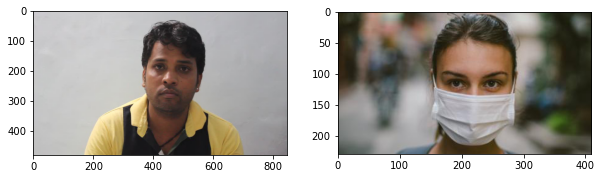

In [16]:
im1 = train_wm_images[0] # sin tapabocas
im2 = train_m_images[0] # con tapabocas
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(im1);
ax[1].imshow(im2);

### Aplicacion del algoritmo de Viola-Jones

In [17]:
#Cargando los clasificadores (en formato XML)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [18]:
gray_1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

In [19]:
# Realiza la deteccion de rostros
faces_1 = face_cascade.detectMultiScale(gray_1, 1.3, 5)
faces_2 = face_cascade.detectMultiScale(gray_2, 1.3, 5)

In [20]:
# Dibuja rectangulos en las caras y ojos
marked_1 = deepcopy(im1)
for (x,y,w,h) in faces_1:
    #marked_1 = cv2.rectangle(marked_1,(x,y),(x+w,y+h),(255,0,0),2)
    # Seleccion en escala de grises de la cara
    roi_gray_1 = gray_1[y:y+h, x:x+w]
    # Seleccion a color de la cara
    roi_color_1 = marked_1[y:y+h, x:x+w]

In [21]:
# Dibuja rectangulos en las caras y ojos
marked_2 = deepcopy(im2)
for (x,y,w,h) in faces_2:
    #marked_2 = cv2.rectangle(marked_2,(x,y),(x+w,y+h),(255,0,0),2)
    # Seleccion en escala de grises de la cara
    roi_gray_2 = gray_2[y:y+h, x:x+w]
    # Seleccion a color de la cara
    roi_color_2 = marked_2[y:y+h, x:x+w]

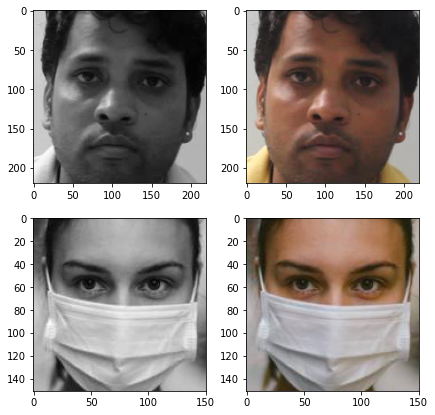

In [25]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].imshow(roi_gray_1, cmap="gray");
ax[0,1].imshow(roi_color_1);
ax[1,0].imshow(roi_gray_2, cmap="gray");
ax[1,1].imshow(roi_color_2);

Ya logramos implementar un codigo que detecte caras (con y sin tapabocas). Hay que confirmar que tan bien funciona aplicandolo al resto de las imágenes.


In [53]:
# detección de caras para todas las imagenes con y sin tapabocas
train_faces_no_mask = []
train_faces_mask = []

# Para caras sin tapabocas
print("Detectando caras...")
for i in range(len(train_wm_images)):
    train_faces_no_mask.append(get_face(train_wm_images[i]))

print("Caras sin tapabocas detectadas!")
# Para caras con tapaocas
for i in range(len(train_m_images)):
    train_faces_mask.append(get_face(train_m_images[i]))
    
print("Caras con tapabocas detectadas!")

Detectando caras...
Caras sin tapabocas detectadas!
Caras con tapabocas detectadas!


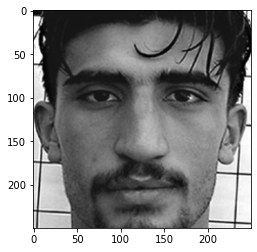

In [54]:
plt.imshow(train_faces_no_mask[34], cmap="gray");

**El algoritmo de Viola y Jones no detecta las caras con tapabocas siempre**.

# 2. Extracción de características

## 2.1 Descriptores estadísticos
**Nota:** confirmar si uniformidad está calculada correctamente

In [61]:
df_stat_no_mask = get_statistic_features(train_faces_no_mask)

In [64]:
print(df_stat_no_mask.shape)
df_stat_no_mask.head()

(378, 9)


,media,desviacion estándar,skewness,curtosis,minimo,maximo,contraste,uniformidad,entropia
0,0.351001,0.204050,0.886591,-0.137641,0.072102,0.962179,0.039972,0.008121,5.005284
1,0.636112,0.225038,-0.821977,-0.076337,0.000601,0.999986,0.048201,0.005809,5.304812
2,0.602493,0.248996,-0.602304,-0.792188,0.000000,0.999433,0.058380,0.006152,5.310564
3,0.361667,0.239644,-0.230741,-1.126455,0.000000,0.999215,0.054310,0.018852,4.899830
4,0.475214,0.210701,-0.511963,-0.974566,0.016653,0.910793,0.042508,0.006258,5.185263


## 2.2 Momentos

## 2.3 Descriptores adicionales